In [1]:
import pandas as pd
import numpy as np
from preprocessing.dataset import EEGDataModule
from preprocessing.standardization import EEGPreprocessor, normalize_features
import torch

In [2]:
path = '../data/BEED_Data.csv'

In [3]:
df = pd.read_csv(path)

In [4]:
print("=== Loading and Examining Data ===")
data = pd.read_csv(path)
print(f"Original data shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

=== Loading and Examining Data ===
Original data shape: (8000, 17)
Columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'y']


In [5]:
data_normalized = normalize_features(data, method='zscore')  # Standard scaling

data_normalized = data.copy()

In [6]:
preprocessor = EEGPreprocessor(
    scaler_type='standard',  # 'standard', 'minmax', or 'robust'
    apply_pca=False,         # dimensionality reduction
    n_components=None,     
    remove_outliers=False,   
    outlier_threshold=3.0    # Z-score threshold for outlier detection
)


In [7]:
data_transformed = preprocessor.fit_transform(data_normalized)
print(f"Transformed data shape: {data_transformed.shape}")

preprocessing_info = preprocessor.get_preprocessing_info()
print(f"Preprocessing info: {preprocessing_info}")

Fitting preprocessor with standard scaler
Transformed data shape: (8000, 17)
Preprocessing info: {'scaler_type': 'standard', 'apply_pca': False, 'n_features_original': 16, 'is_fitted': True, 'feature_names': ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16']}


In [8]:
print("\n=== Creating Data Loaders ===")
data_module = EEGDataModule(
    path,
    test_size=0.2,
    val_size=0.2,
    batch_size=32,
    random_state=42
)
train_loader, val_loader, test_loader = data_module.get_data_loaders()


=== Creating Data Loaders ===
Loading data from ../data/BEED_Data.csv
Loaded 8000 samples
Train set: 5120 samples
Validation set: 1280 samples
Test set: 1600 samples
Dataset created with 5120 samples and 16 features
Feature columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16']
Target distribution: [1280 1280 1280 1280]
Dataset created with 1280 samples and 16 features
Feature columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16']
Target distribution: [320 320 320 320]
Dataset created with 1600 samples and 16 features
Feature columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16']
Target distribution: [400 400 400 400]
Created data loaders with batch size 32


In [9]:
print("\n=== Verifying Data Loaders ===")
for batch_idx, (data_batch, target_batch) in enumerate(train_loader):
    print(f"Training batch {batch_idx + 1}:")
    print(f"  Data shape: {data_batch.shape}")
    print(f"  Target shape: {target_batch.shape}")
    print(f"  Data range: [{data_batch.min():.3f}, {data_batch.max():.3f}]")
    print(f"  Target values: {torch.unique(target_batch).tolist()}")
    break

for batch_idx, (data_batch, target_batch) in enumerate(test_loader):
    print(f"Test batch {batch_idx + 1}:")
    print(f"  Data shape: {data_batch.shape}")
    print(f"  Target shape: {target_batch.shape}")
    print(f"  Data range: [{data_batch.min():.3f}, {data_batch.max():.3f}]")
    print(f"  Target values: {torch.unique(target_batch).tolist()}")
    break



=== Verifying Data Loaders ===
Training batch 1:
  Data shape: torch.Size([32, 16])
  Target shape: torch.Size([32])
  Data range: [-159.000, 144.000]
  Target values: [0, 1, 2, 3]
Test batch 1:
  Data shape: torch.Size([32, 16])
  Target shape: torch.Size([32])
  Data range: [-174.000, 168.000]
  Target values: [0, 1, 2, 3]


In [10]:
# model = UNet1D(in_channels=16, num_classes=4, depth=4)

# # model = UNet1D_Simplified(in_channels=16, num_classes=4)

# # Factory function
# # model = create_unet1d(in_channels=16, num_classes=4, depth=4, simplified=False)

In [11]:
from utils.losses import calculate_class_weights
from utils.metrics import ClassificationMetrics
from utils.optimizers import get_adam_config, create_optimizer_scheduler
from loops.train import train_model
from loops.test import test_model

In [12]:
print("Calculating class weights...")
class_weights = calculate_class_weights(train_loader)
print(f"Class weights: {class_weights}")

Calculating class weights...
Class weights: tensor([1., 1., 1., 1.])


In [13]:
from models.resnet import create_resnet1d

model = create_resnet1d('resnet18', num_classes=4, input_channels=16, simplified=False)
print(f"ResNet model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print(model)

optimizer_config = get_adam_config(lr=0.001, weight_decay=1e-5)
optimizer, scheduler = create_optimizer_scheduler(model, optimizer_config)

train_config = {
    'num_epochs': 50,
    'learning_rate': 0.001,
    'optimizer_type': 'adam',
    'loss_type': 'focal',
    'early_stopping_patience': 10,
    'use_class_weights': True,
    'save_best_model': True,
    'model_save_path': 'models/',
    'log_interval': 10,
    'loss_params': {'alpha': class_weights, 'gamma': 2.0}
}

print("\n=== Starting Training ===")
trainer = train_model(model, train_loader, val_loader, train_config, device='cpu')


ResNet model created with 956,612 parameters
ResNet_EEG(
  (input_layer): Linear(in_features=16, out_features=64, bias=True)
  (layer1): ResidualBlock(
    (fc1): Linear(in_features=64, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (shortcut): Linear(in_features=64, out_features=128, bias=True)
  )
  (layer2): ResidualBlock(
    (fc1): Linear(in_features=128, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (shortcut): Linear(in_features=128, out_features=256, bias=True)
  )
  (layer3): ResidualBlock(
    (fc1): Linear(in_features=256, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (shortcut): Linear(in_features=256, out_features=512, bias=True)
  )
  (final_layer): Linear(in_features=512, out_features=512,

Epoch 1/50: 100%|██████████| 160/160 [00:01<00:00, 132.20it/s, Loss=5.2220, Acc=0.4416] 



Epoch 1/50 (1.31s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.4473
Precision (Macro): 0.4313
Recall (Macro): 0.4473
F1-Score (Macro): 0.4195
Cohen's Kappa: 0.2630
Matthews Correlation: 0.2724
ROC AUC (OVR): 0.7164
ROC AUC (OVO): 0.7164

Validation Metrics:

Metrics:
Accuracy: 0.6813
Precision (Macro): 0.6848
Recall (Macro): 0.6812
F1-Score (Macro): 0.6811
Cohen's Kappa: 0.5750
Matthews Correlation: 0.5761
ROC AUC (OVR): 0.8882
ROC AUC (OVO): 0.8882

Learning Rate: 0.001000
Model saved to models/best_model.pth


Epoch 2/50: 100%|██████████| 160/160 [00:01<00:00, 133.98it/s, Loss=2.8203, Acc=0.5927]



Epoch 2/50 (1.28s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.5941
Precision (Macro): 0.5781
Recall (Macro): 0.5941
F1-Score (Macro): 0.5833
Cohen's Kappa: 0.4589
Matthews Correlation: 0.4602
ROC AUC (OVR): 0.8303
ROC AUC (OVO): 0.8303

Validation Metrics:

Metrics:
Accuracy: 0.6898
Precision (Macro): 0.7249
Recall (Macro): 0.6898
F1-Score (Macro): 0.6870
Cohen's Kappa: 0.5865
Matthews Correlation: 0.6018
ROC AUC (OVR): 0.8940
ROC AUC (OVO): 0.8940

Learning Rate: 0.001000
Model saved to models/best_model.pth


Epoch 3/50: 100%|██████████| 160/160 [00:01<00:00, 128.10it/s, Loss=2.3853, Acc=0.6382]



Epoch 3/50 (1.34s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.6371
Precision (Macro): 0.6298
Recall (Macro): 0.6371
F1-Score (Macro): 0.6330
Cohen's Kappa: 0.5161
Matthews Correlation: 0.5164
ROC AUC (OVR): 0.8557
ROC AUC (OVO): 0.8557

Validation Metrics:

Metrics:
Accuracy: 0.6789
Precision (Macro): 0.7371
Recall (Macro): 0.6789
F1-Score (Macro): 0.6780
Cohen's Kappa: 0.5719
Matthews Correlation: 0.5836
ROC AUC (OVR): 0.8903
ROC AUC (OVO): 0.8903

Learning Rate: 0.001000


Epoch 4/50: 100%|██████████| 160/160 [00:01<00:00, 135.93it/s, Loss=0.8576, Acc=0.6587]



Epoch 4/50 (1.26s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.6600
Precision (Macro): 0.6562
Recall (Macro): 0.6600
F1-Score (Macro): 0.6578
Cohen's Kappa: 0.5466
Matthews Correlation: 0.5467
ROC AUC (OVR): 0.8711
ROC AUC (OVO): 0.8711

Validation Metrics:

Metrics:
Accuracy: 0.6992
Precision (Macro): 0.7550
Recall (Macro): 0.6992
F1-Score (Macro): 0.6993
Cohen's Kappa: 0.5990
Matthews Correlation: 0.6156
ROC AUC (OVR): 0.9024
ROC AUC (OVO): 0.9024

Learning Rate: 0.001000
Model saved to models/best_model.pth


Epoch 5/50: 100%|██████████| 160/160 [00:01<00:00, 136.70it/s, Loss=0.6938, Acc=0.6883]



Epoch 5/50 (1.26s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.6906
Precision (Macro): 0.6898
Recall (Macro): 0.6906
F1-Score (Macro): 0.6900
Cohen's Kappa: 0.5875
Matthews Correlation: 0.5876
ROC AUC (OVR): 0.8862
ROC AUC (OVO): 0.8862

Validation Metrics:

Metrics:
Accuracy: 0.6898
Precision (Macro): 0.7663
Recall (Macro): 0.6898
F1-Score (Macro): 0.6794
Cohen's Kappa: 0.5865
Matthews Correlation: 0.6153
ROC AUC (OVR): 0.9120
ROC AUC (OVO): 0.9120

Learning Rate: 0.001000


Epoch 6/50: 100%|██████████| 160/160 [00:01<00:00, 129.08it/s, Loss=0.6222, Acc=0.6889]



Epoch 6/50 (1.32s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.6930
Precision (Macro): 0.6917
Recall (Macro): 0.6930
F1-Score (Macro): 0.6922
Cohen's Kappa: 0.5906
Matthews Correlation: 0.5907
ROC AUC (OVR): 0.8922
ROC AUC (OVO): 0.8922

Validation Metrics:

Metrics:
Accuracy: 0.7648
Precision (Macro): 0.7927
Recall (Macro): 0.7648
F1-Score (Macro): 0.7613
Cohen's Kappa: 0.6865
Matthews Correlation: 0.7002
ROC AUC (OVR): 0.9384
ROC AUC (OVO): 0.9384

Learning Rate: 0.001000
Model saved to models/best_model.pth


Epoch 7/50: 100%|██████████| 160/160 [00:01<00:00, 135.82it/s, Loss=1.0740, Acc=0.7119]



Epoch 7/50 (1.27s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7113
Precision (Macro): 0.7099
Recall (Macro): 0.7113
F1-Score (Macro): 0.7106
Cohen's Kappa: 0.6151
Matthews Correlation: 0.6151
ROC AUC (OVR): 0.9025
ROC AUC (OVO): 0.9025

Validation Metrics:

Metrics:
Accuracy: 0.7977
Precision (Macro): 0.8245
Recall (Macro): 0.7977
F1-Score (Macro): 0.7938
Cohen's Kappa: 0.7302
Matthews Correlation: 0.7430
ROC AUC (OVR): 0.9509
ROC AUC (OVO): 0.9509

Learning Rate: 0.001000
Model saved to models/best_model.pth


Epoch 8/50: 100%|██████████| 160/160 [00:01<00:00, 138.94it/s, Loss=0.3304, Acc=0.7200]



Epoch 8/50 (1.24s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7199
Precision (Macro): 0.7199
Recall (Macro): 0.7199
F1-Score (Macro): 0.7198
Cohen's Kappa: 0.6266
Matthews Correlation: 0.6266
ROC AUC (OVR): 0.9099
ROC AUC (OVO): 0.9099

Validation Metrics:

Metrics:
Accuracy: 0.7484
Precision (Macro): 0.7869
Recall (Macro): 0.7484
F1-Score (Macro): 0.7470
Cohen's Kappa: 0.6646
Matthews Correlation: 0.6779
ROC AUC (OVR): 0.9365
ROC AUC (OVO): 0.9365

Learning Rate: 0.001000


Epoch 9/50: 100%|██████████| 160/160 [00:01<00:00, 134.34it/s, Loss=0.5412, Acc=0.7405]



Epoch 9/50 (1.28s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7426
Precision (Macro): 0.7434
Recall (Macro): 0.7426
F1-Score (Macro): 0.7429
Cohen's Kappa: 0.6568
Matthews Correlation: 0.6568
ROC AUC (OVR): 0.9219
ROC AUC (OVO): 0.9219

Validation Metrics:

Metrics:
Accuracy: 0.7898
Precision (Macro): 0.8245
Recall (Macro): 0.7898
F1-Score (Macro): 0.7902
Cohen's Kappa: 0.7198
Matthews Correlation: 0.7326
ROC AUC (OVR): 0.9477
ROC AUC (OVO): 0.9477

Learning Rate: 0.001000


Epoch 10/50: 100%|██████████| 160/160 [00:01<00:00, 138.64it/s, Loss=0.2670, Acc=0.7670]



Epoch 10/50 (1.24s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7637
Precision (Macro): 0.7644
Recall (Macro): 0.7637
F1-Score (Macro): 0.7639
Cohen's Kappa: 0.6849
Matthews Correlation: 0.6850
ROC AUC (OVR): 0.9263
ROC AUC (OVO): 0.9263

Validation Metrics:

Metrics:
Accuracy: 0.7969
Precision (Macro): 0.8213
Recall (Macro): 0.7969
F1-Score (Macro): 0.8006
Cohen's Kappa: 0.7292
Matthews Correlation: 0.7347
ROC AUC (OVR): 0.9535
ROC AUC (OVO): 0.9535

Learning Rate: 0.000100
Model saved to models/best_model.pth


Epoch 11/50: 100%|██████████| 160/160 [00:01<00:00, 138.69it/s, Loss=0.3556, Acc=0.7794]



Epoch 11/50 (1.24s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7775
Precision (Macro): 0.7782
Recall (Macro): 0.7775
F1-Score (Macro): 0.7776
Cohen's Kappa: 0.7034
Matthews Correlation: 0.7035
ROC AUC (OVR): 0.9356
ROC AUC (OVO): 0.9356

Validation Metrics:

Metrics:
Accuracy: 0.7922
Precision (Macro): 0.8217
Recall (Macro): 0.7922
F1-Score (Macro): 0.7952
Cohen's Kappa: 0.7229
Matthews Correlation: 0.7309
ROC AUC (OVR): 0.9526
ROC AUC (OVO): 0.9526

Learning Rate: 0.000100


Epoch 12/50: 100%|██████████| 160/160 [00:01<00:00, 123.93it/s, Loss=0.1879, Acc=0.7562]



Epoch 12/50 (1.37s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7582
Precision (Macro): 0.7609
Recall (Macro): 0.7582
F1-Score (Macro): 0.7593
Cohen's Kappa: 0.6776
Matthews Correlation: 0.6777
ROC AUC (OVR): 0.9285
ROC AUC (OVO): 0.9285

Validation Metrics:

Metrics:
Accuracy: 0.7937
Precision (Macro): 0.8262
Recall (Macro): 0.7938
F1-Score (Macro): 0.7953
Cohen's Kappa: 0.7250
Matthews Correlation: 0.7363
ROC AUC (OVR): 0.9558
ROC AUC (OVO): 0.9558

Learning Rate: 0.000100


Epoch 13/50: 100%|██████████| 160/160 [00:01<00:00, 136.41it/s, Loss=0.2995, Acc=0.7709]



Epoch 13/50 (1.26s)
--------------------------------------------------
Training Metrics:

Metrics:
Accuracy: 0.7699
Precision (Macro): 0.7706
Recall (Macro): 0.7699
F1-Score (Macro): 0.7700
Cohen's Kappa: 0.6932
Matthews Correlation: 0.6934
ROC AUC (OVR): 0.9332
ROC AUC (OVO): 0.9332

Validation Metrics:

Metrics:
Accuracy: 0.8031
Precision (Macro): 0.8311
Recall (Macro): 0.8031
F1-Score (Macro): 0.8049
Cohen's Kappa: 0.7375
Matthews Correlation: 0.7468
ROC AUC (OVR): 0.9588
ROC AUC (OVO): 0.9588

Learning Rate: 0.000100
Early stopping triggered at epoch 13

Training completed in 16.78 seconds
Best validation metric: 0.8006 at epoch 10
Model saved to models/final_model.pth



=== Starting Testing ===
Starting testing on cpu

TEST RESULTS

Metrics:
Accuracy: 0.7831
Precision (Macro): 0.8105
Recall (Macro): 0.7831
F1-Score (Macro): 0.7847
Cohen's Kappa: 0.7108
Matthews Correlation: 0.7197
ROC AUC (OVR): 0.9472
ROC AUC (OVO): 0.9472


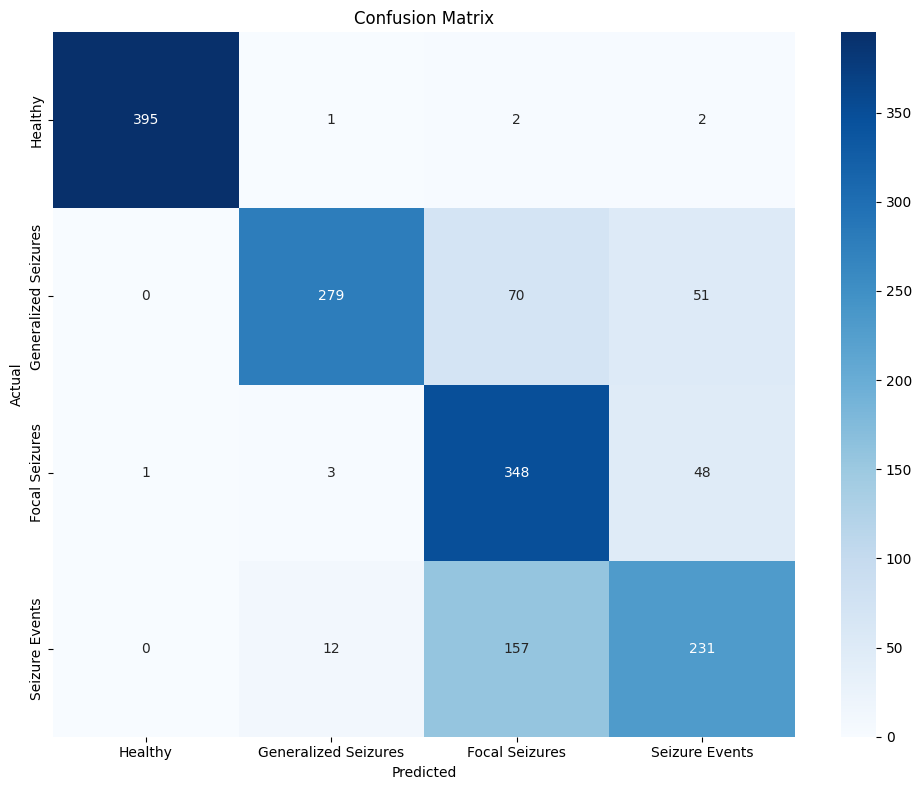

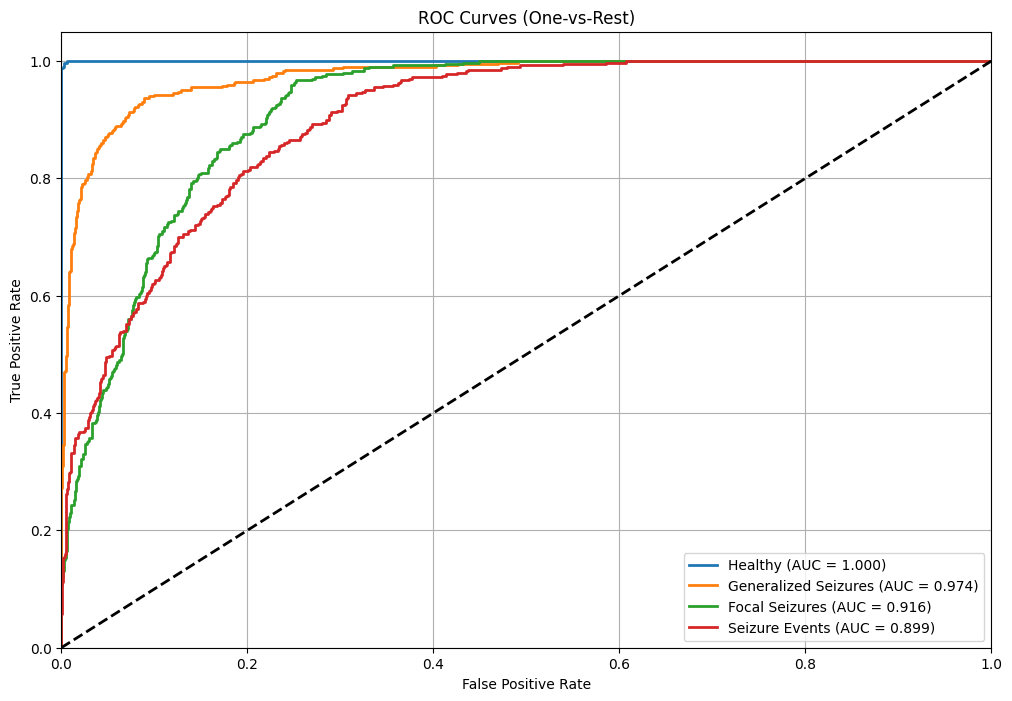

Predictions saved to results/predictions.csv

=== Final Results ===
Test Accuracy: 0.7831
Test F1 Score: 0.7847
Test Precision: 0.8105
Test Recall: 0.7831
Training history plot saved to results/training_history.png


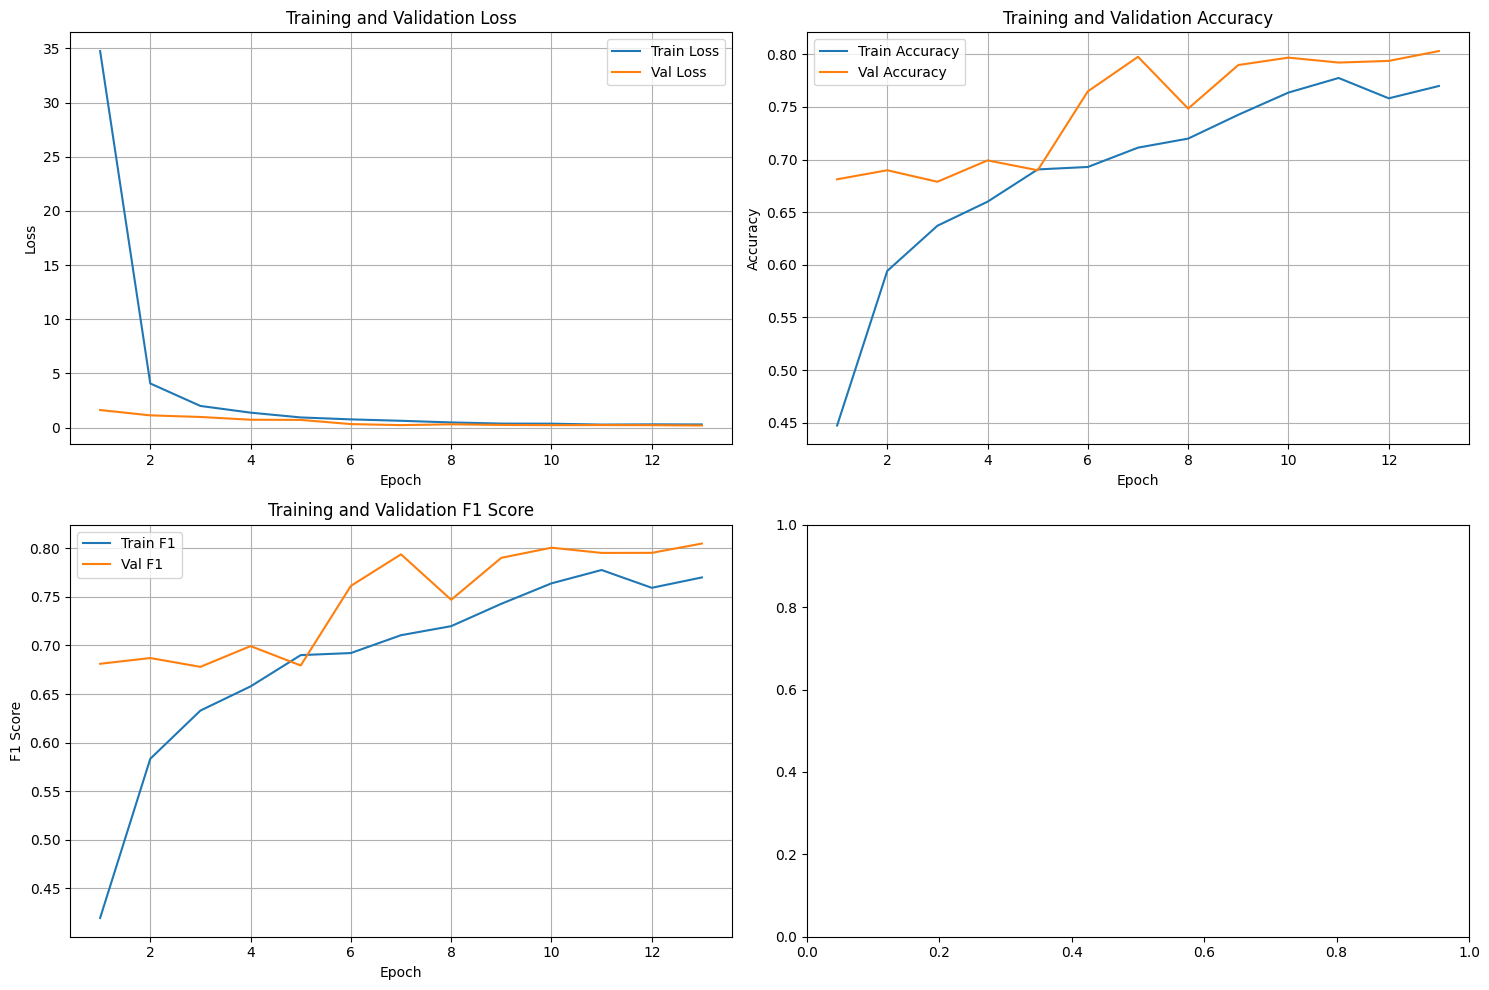

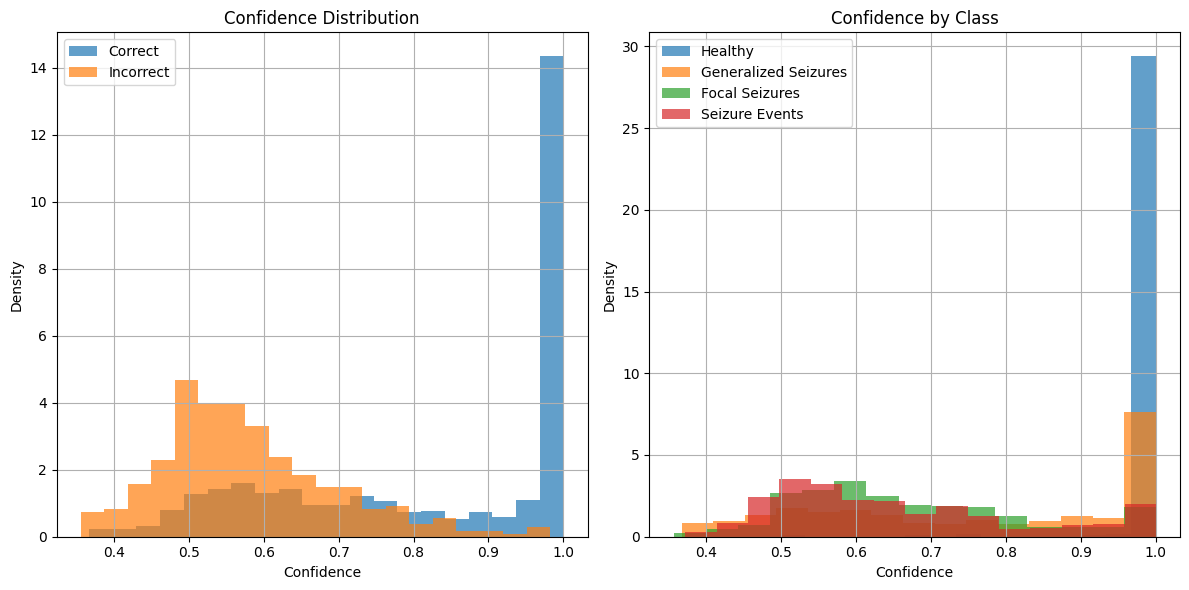

In [14]:
test_config = {
    'save_predictions': True,
    'save_confusion_matrix': True,
    'class_names': ['Healthy', 'Generalized Seizures', 'Focal Seizures', 'Seizure Events']
}

print("\n=== Starting Testing ===")
tester = test_model(model, test_loader, device='cpu', config=test_config)

print("\n=== Final Results ===")
final_metrics = tester.test_metrics.compute()
print(f"Test Accuracy: {final_metrics['accuracy']:.4f}")
print(f"Test F1 Score: {final_metrics['f1_macro']:.4f}")
print(f"Test Precision: {final_metrics['precision_macro']:.4f}")
print(f"Test Recall: {final_metrics['recall_macro']:.4f}")

trainer.plot_training_history(save_path='results/training_history.png')

tester.plot_confidence_distribution()